# Learn to Rank - Personalized IR

Armanni Luca - 509085

Ghiotto Alessandro - 513944

---

In this last notebook we are going to train a model for ranking the documents, given a set of output features. In this features we are encluding the score given by the tags, that leads to an output depending on the user profile and not just the query itself.

- Random Forest
- Gradient Boosting
- Conlusions

In [1]:
### FOR COLAB

# !pip install -q condacolab
# import condacolab
# condacolab.install()

# !conda install -c pytorch faiss-gpu -y
# !conda install -c conda-forge py-xgboost -y

# !pip install --upgrade -q python-terrier
# !pip install -q sentence_transformers ipdb emoji
# !pip Install -q pyterrier-caching

# !gdown 1HhgXzyEpsZNcenU9XhJuOYyDUKEzUse4
# !unzip pir_data.zip

In [2]:
import pandas as pd
import re
import os
import warnings
import shutil
import torch
import numpy as np
import random
import time
import faiss
import joblib
from functools import partial
import math

# Hugging Face
from sentence_transformers import SentenceTransformer

# VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# TEXT PROCESSING
from textblob import TextBlob
import emoji
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# TERRIER
from pyterrier.measures import *
import pyterrier as pt
from pyterrier_caching import RetrieverCache

# Move to the parent directory
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

if not pt.java.started():
    pt.utils.set_tqdm('notebook')
    pt.java.init()

# SET SEED
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

Java started and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]


In [3]:
##### UTILITY function
### DISPLAY STYLED df
# set with colors highest values in each column
def display_styled(df, ignore_cols=[], color="#37614a"):
    """ignore_cols: list of columns to not color"""
    def highlight_max(s):
        if s.name in ignore_cols:  # Skip styling for the 'Name' column
            return ['' for _ in s]
        is_max = s == s.max()
        return [f'font-weight: bold; background-color: {color};' if v else '' for v in is_max]

    styled_df = (
        df.style
        .apply(highlight_max, axis=0)  # Apply styling
        .format({col: "{:.3f}" for col in df.select_dtypes(include='number').columns})  # Format numeric columns only
    )
    display(styled_df)
    return None

Load data

In [4]:
stemmer = PorterStemmer()
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

def preprocess_text(text, apply_stemmer=False, remove_stopwords=False):
    # remove emojis
    text = emoji.replace_emoji(text, "")
    # remove links
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    # remove html tags
    # text = BeautifulSoup(text, "html.parser").get_text(separator=" ")
    # lowercase verything
    text = text.lower()
    # remove backslashes
    text = re.sub(r"\\", "", text)
    # remove special characters and punctuation
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    # remove whitespaces
    text = re.sub(r"\s+", " ", text)
    # remove leading and trailing whites
    text = text.strip()
    # apply spelling correction
    # text = TextBlob(text).correct()
    tokens = text.split()
    if remove_stopwords:
        tokens = [t for t in tokens if t not in stop_words]
    if apply_stemmer:
        tokens = [stemmer.stem(t) for t in tokens]
    return " ".join(tokens)

[nltk_data] Downloading package stopwords to /home/ghi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# COLLECTION OF DOCUMENTS (ANSWERS)
def preprocess_corpus(df):
    df = df.reset_index()
    df.columns = ['docno', 'text']
    df = df.reset_index(drop=True)
    return df

corpus_df = preprocess_corpus(pd.read_json('PIR_data/answer_retrieval/subset_answers.json', orient='index'))

# SAMPLES (QUERIES)
def preprocess_queries_df(path):
    df = pd.read_json(path, lines=True)
    df = df[['id', 'text', 'user_id', 'timestamp']]
    df.columns = ['qid', 'query_unprocessed', 'user_id', 'timestamp']
    df['query'] = df['query_unprocessed'].apply(lambda x: preprocess_text(x, apply_stemmer=True, remove_stopwords=True))
    df['timestamp'] = df["timestamp"].astype(int) // 10**9
    df['user_id'] = df['user_id'].astype(str)
    df = df.reset_index(drop=True)
    return df

train_queries = preprocess_queries_df('PIR_data/answer_retrieval/train/subset_data.jsonl')
val_queries = preprocess_queries_df('PIR_data/answer_retrieval/val/subset_data.jsonl')
test_queries = preprocess_queries_df('PIR_data/answer_retrieval/test/subset_data.jsonl')

# QRELS
def preprocess_qrels_df(path):
    df = pd.read_json(path, orient='index').reset_index()
    df.columns = ['qid', 'docno']
    df['label'] = 1
    df = df.reset_index(drop=True)
    return df

train_qrels = preprocess_qrels_df('PIR_data/answer_retrieval/train/qrels.json')
val_qrels = preprocess_qrels_df('PIR_data/answer_retrieval/val/qrels.json')
test_qrels = preprocess_qrels_df('PIR_data/answer_retrieval/test/qrels.json')

print("ANSWERS")
display(corpus_df.head(3))
print("QUERIES")
display(train_queries.head(3))
print("QRELS")
display(train_qrels.head(3)) 

ANSWERS


,docno,text
0,writers_2010,TL;DRIf you're going to do present tense do it...
1,writers_2018,"Your writing style is stream-of-consciousness,..."
2,writers_2023,Place emphasis on uncomfortable things. Depend...


QUERIES


,qid,query_unprocessed,user_id,timestamp,query
0,academia_100305,What are CNRS research units and how are they ...,1106095,1513009820,cnr research unit staf centr nation de la rech...
1,academia_100456,Is there a free (as in freedom) alternative to...,1106095,1513191752,free freedom altern publon review journal allo...
2,academia_103390,Search for StackExchange citations with Google...,1532620,1517935259,search stackexchang citat googl scholar possib...


QRELS


,qid,docno,label
0,academia_100305,academia_100217,1
1,academia_100456,academia_100462,1
2,academia_103390,academia_103391,1


In [6]:
##### REPORTED FROM PREVIOUS NOTEBOOK
### BIENCODER MODEL

def _get_dense_scores(df, FAISS_INDEX, biencoder_model, text_field='query_unprocessed', k=1000):
    """
    get cosine similarity score with a biencoder model, with FAISS FlatIndex

    used as argument of pyterrier.apply.doc_score()
        =>  the input is a ranked documents dataframe (batch), by query
            the output are the scores for each document in the batch
    """
    if not all(df['qid'] == df['qid'].iloc[0]):
        assert "Not all qids in the batch are equal"
    # get the query unprocessed text
    query_text = df[text_field].iloc[0]
    # get the query embedding
    query_embedding = biencoder_model.encode(query_text).astype('float32')
    query_embedding = query_embedding / np.linalg.norm(query_embedding) # normalize for cosine similarity

    # if we are reranking
    if 'docid' in df.columns:
        # select the retrieved documents
        filter_ids = df['docid'].values
        id_selector = faiss.IDSelectorArray(np.array(filter_ids, dtype=np.int64))
        search_params = faiss.SearchParametersIVF(sel=id_selector)
        # rerank them
        k = len(filter_ids)
        distances, indices = FAISS_INDEX.search(np.array([query_embedding]), k, params=search_params)
    else:
        distances, indices = FAISS_INDEX.search(np.array([query_embedding]), k)

    # mapping {docid: score}
    score_mapping = {docid: score for docid, score in zip(indices[0], distances[0])}
    # get the scores in the original order (same as the input docids)
    scores_original_order = [score_mapping[docid] for docid in df['docid']]
    return scores_original_order

In [7]:
##### REPORTED FROM PREVIOUS NOTEBOOK
### TAGS SCORE

path = './index_sepqa/user_tags_full.joblib'
USER_TAGS = joblib.load(path)

def get_user_tags(user_id, timestamp, include_curr_timestamp, user_tags=USER_TAGS):
    """
    Get the tags of a user at a given timestamp.

    include_curr_timestamp: if True, the tags at the given timestamp are included.
                            if False, the tags at the given timestamp are excluded.
    """
    tags = set()
    timestamp = int(timestamp)
    
    if include_curr_timestamp == False:
        timestamp -= 1 # exclude the question at the given timestamp

    # if the user_id is not in the user_tags dictionary, return an empty set (no profile for the user)
    if user_id not in user_tags:
        return tags
    
    for ts, user_tags in user_tags[user_id]:
        if ts <= timestamp:
            tags = tags.union(user_tags)
        # the ts are sorted, so we can break when we reach the timestamp
        else:
            break
    return tags

def _get_tags_score(df, get_user_tags_fn=get_user_tags):
    """
    get scores based on the tags of the user that asked the question
    and the user that have written the answer.

    used as argument of pyterrier.apply.doc_score()
        =>  the input is a ranked documents dataframe (batch), by query
            the output are the scores for each document in the batch
    """
    
    def compute_score(tags_uq, tags_ua):
        """
        tags_uq: set of tags of the user that asked the question
        tags_ua: set of tags of the user that wrote the answer
        """
        return len(tags_uq.intersection(tags_ua)) / (len(tags_uq) + 1)

    if not all(df['qid'] == df['qid'].iloc[0]):
        assert "Not all qids in the batch are equal"
    # user of the query
    uq = df['user_id'].iloc[0]
    # timestamp of the query
    tq = df['timestamp'].iloc[0]
    # get the tags of the user that asked the question
    tags_uq = get_user_tags_fn(uq, tq, include_curr_timestamp=True)

    # users that have written the answers
    uaS = df['doc_user_id'].values
    # get the tags of the users that have written the answers
    tags_uaS = [get_user_tags_fn(ua, tq, include_curr_timestamp=False) for ua in uaS]
    # compute the score for each answer
    scores = [compute_score(tags_uq, tags_ua) for tags_ua in tags_uaS]
    return scores


In [8]:
##### REPORTED FROM PREVIOUS NOTEBOOK
### NUM QUESTIONS


def get_user_num_questions(user_id, timestamp, user_tags=USER_TAGS):
    """
    Get the number of questions that a user have written at a given timestamp.
    the current timestamp is included.
    """
    num_questions = 0
    timestamp = int(timestamp)
    
    # if the user_id is not in the user_tags dictionary, return 0 (no profile for the user)
    if user_id not in user_tags:
        return num_questions
    
    for ts, user_tags in user_tags[user_id]:
        if ts <= timestamp:
            num_questions += 1
        # early stopping since the timestamps are sorted
        else:
            break
    return num_questions

# THE NUM_QUESTIONS IS REFERRED TO THE USER THAT ASKED THE QUESTION
def _get_num_questions(df, get_user_num_questions_fn=get_user_num_questions):
    """
    get the number of questions of the user that asked the question
    """
    if not all(df['qid'] == df['qid'].iloc[0]):
        assert "Not all qids in the batch are equal"
    # user of the query
    uq = df['user_id'].iloc[0]
    # timestamp of the query
    tq = df['timestamp'].iloc[0]
    # get the number of questions of the user that asked the question
    scores = [get_user_num_questions_fn(uq, tq)]
    scores = scores * len(df) # repeat the score for each document in the batch
    return scores


Here we build the pipeline that output the following features: [norm_bi_enc, norm_bm25, norm_tags_score]

In [9]:
### BM25
path = "./index_sepqa/index_bm25_users/data.properties"
bm25_index = pt.IndexFactory.of(path)
bm25 = pt.terrier.Retriever(
    bm25_index, 
    wmodel="BM25", 
    controls={'c': 1.0, 'bm25.k_1': 2.5},
    properties={"termpipelines": ""}, 
    metadata=["docno", "doc_user_id"] # ADD doc_user_id TO THE METADATA TO BE RETRIEVED
)
norm_bm25 = bm25 >> pt.pipelines.PerQueryMaxMinScoreTransformer() ## NORMALIZE THE SCORES

### BI-ENCODER
index_path = "./index_sepqa/MiniLM_faiss_IndexFlatIP.index"
faiss_index = faiss.read_index(index_path)
biencoder_model = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2')
get_dense_score = partial(_get_dense_scores, FAISS_INDEX=faiss_index, biencoder_model=biencoder_model)
bi_enc = pt.apply.doc_score(get_dense_score, batch_size=64)
norm_bi_enc = bi_enc >> pt.pipelines.PerQueryMaxMinScoreTransformer() ## NORMALIZE THE SCORES

### TAGS-SCORE
tags_score = pt.apply.doc_score(_get_tags_score, batch_size=64)
norm_tags_score = tags_score >> pt.pipelines.PerQueryMaxMinScoreTransformer() ## NORMALIZE THE SCORES


##### PIPELINE #####
path_to_cache = "./cache/features_BiEncoder_BM25_Tags_LTR"

features_pipeline = (bm25 % 100).compile() \
                    >> (norm_bi_enc ** norm_bm25 ** norm_tags_score) \
                    >> pt.apply.generic(lambda x: x[['qid', 'docno','features']]) # keep only useful columns
# cache the features
cached_features_retriever = RetrieverCache(path_to_cache, features_pipeline)

---
# Random Forest

We train a [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) model that minimizes the squared error (default `criterion='squared_error'`)

In [10]:
from sklearn.ensemble import RandomForestRegressor

### attach a random forest model
# we take a small random forest model, since we have only 3 features
# this features are also quit straight forward (are just scores, no complex features)
rf = RandomForestRegressor(n_estimators=50, max_depth=12, random_state=seed)
rf_pipe = cached_features_retriever >> pt.ltr.apply_learned_model(rf)

### FIT THE MODEL
model_path = "./models/BiEncoder_BM25_Tags_RF.joblib"
FIT = False

if FIT or not os.path.exists(model_path):
    print("Fitting the model...")
    t0 = time.time()
    rf_pipe.fit(train_queries, train_qrels)
    print("Fitting the model took:", round(time.time()-t0), "seconds")
    ### Fitting the model took: ~ 5 minutes

    # save the model
    joblib.dump(rf, model_path)
    print("Model saved to disk.")
else:
    print("Loading the model from disk...")
    rf = joblib.load(model_path)
    rf_pipe = cached_features_retriever >> pt.ltr.apply_learned_model(rf)


Loading the model from disk...


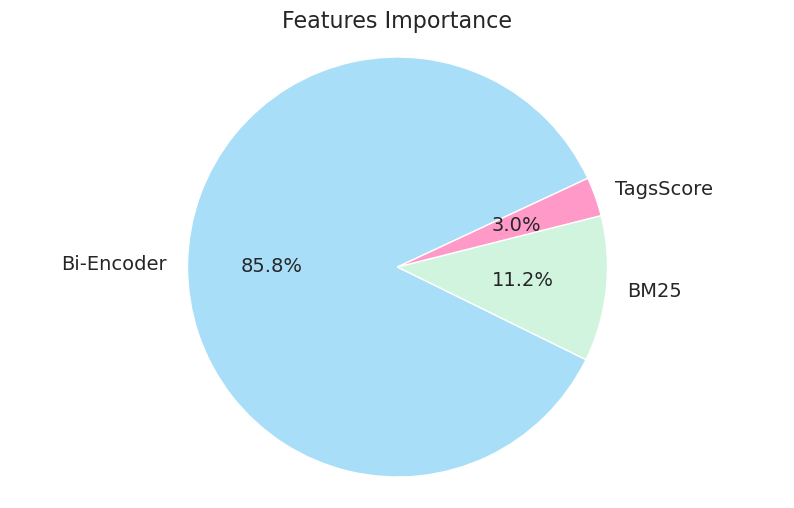

In [11]:
features_importance = rf.feature_importances_
names = ['Bi-Encoder', 'BM25', 'TagsScore']

colors = ['#a9def9', '#d0f4de', '#ff99c8']

plt.figure(figsize=(10, 6))
plt.pie(features_importance, labels=names, autopct='%1.1f%%', startangle=25, 
        colors=colors, textprops={'fontsize': 14})
plt.title('Features Importance', fontsize=16)
plt.axis('equal')
plt.show()

In [12]:
metrics = [P@1, P@3, nDCG@3, nDCG@10, R@100, MAP@100, 'mrt']
save_dir = "./experiments/ltr_personalized_ir/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

all_data = [
    (train_queries, train_qrels, 'train_BiEncoder_BM25_Tags_RF'), 
    (val_queries, val_qrels, 'val_BiEncoder_BM25_Tags_RF'), 
]
results = []
for queries, qrels, name in all_data:
    experiment = pt.Experiment(
        [rf_pipe],
        queries,
        qrels,
        eval_metrics=metrics,
        names=[name],
        save_dir=save_dir,
        save_mode= "overwrite",
    )
    results.append(experiment)

results = pd.concat(results)
path = "./experiments/ltr_personalized_ir/results_BiEncoder_BM25_Tags_RF.csv"
results.to_csv(path)

display(results.round(3))

,name,P@1,P@3,nDCG@3,nDCG@10,R@100,AP@100,mrt
0,train_BiEncoder_BM25_Tags_RF,0.882,0.314,0.920,0.921,0.946,0.912,0.534
0,val_BiEncoder_BM25_Tags_RF,0.918,0.316,0.936,0.940,0.969,0.935,0.549


# XGBoost

We train a XGBRegressor from [XGBoost](https://xgboost.readthedocs.io/en/stable/index.html) that minimizes the mean average precision.

In [13]:
import xgboost

# XGBoost Regressor that minimizes MAP
xgb = xgboost.sklearn.XGBRegressor(
    objective='rank:map',
    learning_rate=0.01,
    max_depth=6,
    random_state=seed,
)

xgb_pipe = cached_features_retriever >> pt.ltr.apply_learned_model(xgb)

### FIT THE MODEL
model_path = "./models/BiEncoder_BM25_Tags_XGB.joblib"
FIT = False

if FIT or not os.path.exists(model_path):
    print("Fitting the model...")
    t0 = time.time()
    xgb_pipe.fit(train_queries, train_qrels)
    print("Fitting the model took:", round(time.time()-t0), "seconds")
    ### Fitting the model took: ~ 1 minute

    # save the model
    joblib.dump(xgb, model_path)
    print("Model saved to disk.")
else:
    print("Loading the model from disk...")
    xgb = joblib.load(model_path)
    xgb_pipe = cached_features_retriever >> pt.ltr.apply_learned_model(xgb)


Loading the model from disk...


In [14]:
metrics = [P@1, P@3, nDCG@3, nDCG@10, R@100, MAP@100, 'mrt']
save_dir = "./experiments/ltr_personalized_ir/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

all_data = [
    (train_queries, train_qrels, 'train_BiEncoder_BM25_Tags_XGB'), 
    (val_queries, val_qrels, 'val_BiEncoder_BM25_Tags_XGB'), 
]

results = []
for queries, qrels, name in all_data:
    experiment = pt.Experiment(
        [xgb_pipe],
        queries,
        qrels,
        eval_metrics=metrics,
        names=[name],
        save_dir=save_dir,
        save_mode= "overwrite",
    )
    results.append(experiment)

results = pd.concat(results)
path = "./experiments/ltr_personalized_ir/results_BiEncoder_BM25_Tags_XGB.csv"
results.to_csv(path)

display(results.round(3))

,name,P@1,P@3,nDCG@3,nDCG@10,R@100,AP@100,mrt
0,train_BiEncoder_BM25_Tags_XGB,0.830,0.301,0.875,0.883,0.946,0.869,0.372
0,val_BiEncoder_BM25_Tags_XGB,0.908,0.313,0.927,0.931,0.969,0.926,0.387


### Ablating features

To analyze the XGBRegressor model, we remove one feature at a time, and we look at the performances of the model without such feature.

In [15]:
# numf: number of features (Bi-Encoder, BM25, TagsScore)
numf = 3
rankers = []
names = []

params = {
    'objective': 'rank:map',
    'learning_rate': 0.01,
    'max_depth': 6,
    'random_state': seed,
}

# learn a model for all four features
full = cached_features_retriever >> pt.ltr.apply_learned_model(xgboost.sklearn.XGBRegressor(**params))

full.fit(train_queries, train_qrels)
rankers.append(full)

# learn a model for 2 features, removing one each time
for fid in range(numf):
    ablated = cached_features_retriever >> pt.ltr.ablate_features(fid) >> pt.ltr.apply_learned_model(xgboost.sklearn.XGBRegressor(**params))
    ablated.fit(train_queries, train_qrels)
    rankers.append(ablated)

# evaluate the full (3 features) model, as well as the each model containing only 2 features
results = pt.Experiment(
    rankers,
    val_queries,
    val_qrels,
    eval_metrics=metrics,
    names=["Full XGB Model"]  + ["Full XGB Minus %d" % fid for fid in range(numf)]
)

display(results.round(3))

,name,P@1,P@3,nDCG@3,nDCG@10,R@100,AP@100,mrt
0,Full XGB Model,0.908,0.313,0.927,0.927,0.969,0.924,0.370
1,Full XGB Minus 0,0.704,0.262,0.753,0.768,0.969,0.754,0.691
2,Full XGB Minus 1,0.857,0.313,0.907,0.907,0.969,0.897,0.684
3,Full XGB Minus 2,0.918,0.313,0.931,0.931,0.969,0.929,0.689


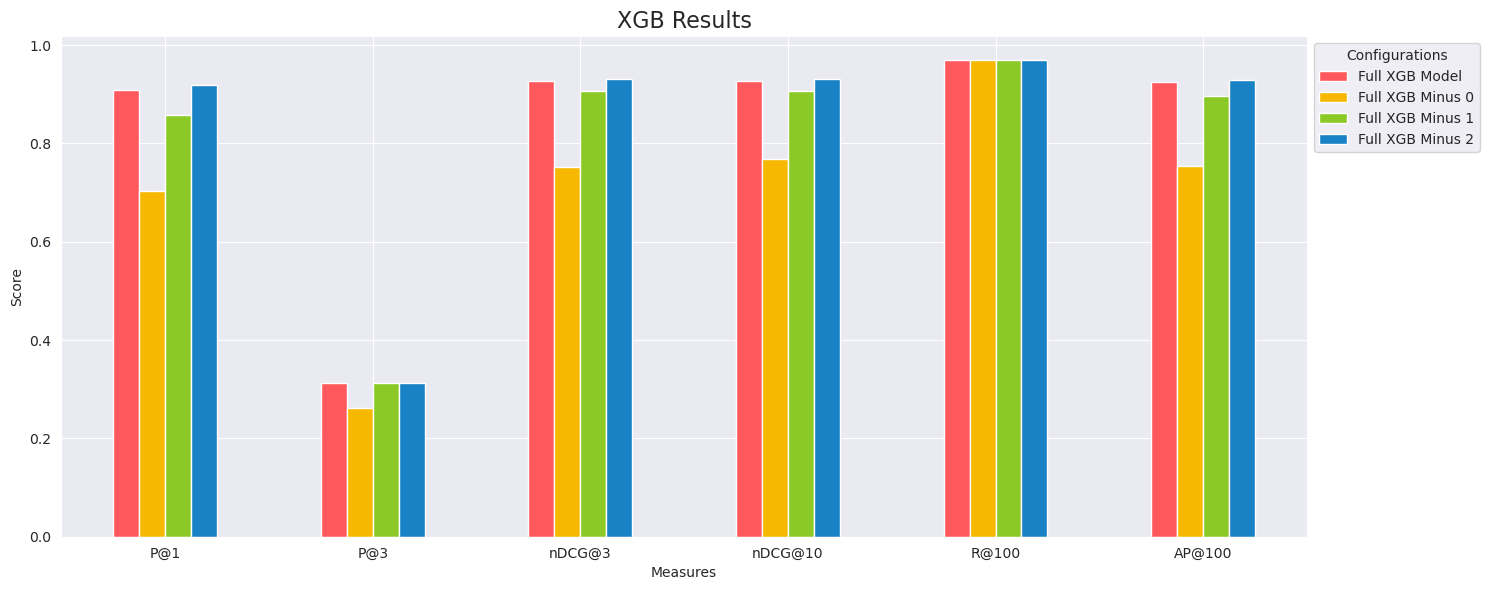

In [16]:
plot_df = results.drop('mrt', axis=1).set_index('name')
colors = ['#ff595e', '#f7b801', '#8ac926', '#1982c4', '#6a4c93']
ax = plot_df.T.plot(kind='bar', figsize=(15, 6), color=colors)

# Customize the plot
plt.title('XGB Results', fontsize=16)
plt.xlabel('Measures')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(title='Configurations', bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()


By ablating one feature at a time we can again confirm that the most important feature is always the score given by the BiEncoder.

---

# Conclusions

Finally we try the most meaningful models on the val set and compare them.

1. best baseline model:  
   
    `bm25`, with parameters $c = 1.0$ and $k_1 = 1.2$
2. non-personalized reranking model A:  
   
    `bm25 % 100 >> bi_enc`
3. non-personalized reranking model B:  

    `bm25 % 100 >> .9*norm_bi_enc + .1*norm_bm25`
4. personalization via Query expansion: 

    `bm25 % 100 >> expand_query >> bi_enc`
5. tags score model (weighted average):  

    `bm25 % 100 >> .7*norm_bi_enc + .1*norm_bm25 + .2*tags_score`
6. tags score model (weighted average with heuristics):
   
$\text{BM25 \% 100} >> 
\begin{cases}
    .7 \cdot \text{BiEncoder\_score} + .1 \cdot \text{BM25\_score} + .2 \cdot \text{tags\_score}, &\quad\text{if \, num\_questions}\ge 512\\
    .9 \cdot \text{BiEncoder\_score} + .1 \cdot \text{BM25\_score}, &\quad\text{otherwise.} \\ 
\end{cases}$

1. tags score model (learn to rank):  
   
    `bm25 % 100 >> (norm_bi_enc ** norm_bm25 ** norm_tags_score) >> RandomForestRegressor`

NOTES:
- BM25 is always applied to text that is stemmed and the stopwords are removed
- BM25 used as first stage retriever have parameters $c = 1.0$ and $k_1 = 2.5$
- the Bi-Encoder used is always *'all-MiniLM-L12-v2'* and is applied to the text unprocessed
- all the models are applied to the full text of the question, not just the title

In [10]:
########## BUILDING BLOCKS ##########

### BM25
path = "./index_sepqa/index_bm25_users/data.properties"
bm25_index = pt.IndexFactory.of(path)
bm25 = pt.terrier.Retriever(
    bm25_index, 
    wmodel="BM25", 
    controls={'c': 1.0, 'bm25.k_1': 2.5},
    properties={"termpipelines": ""}, 
    metadata=["docno", "doc_user_id"] # ADD doc_user_id TO THE METADATA TO BE RETRIEVED
)
norm_bm25 = bm25 >> pt.pipelines.PerQueryMaxMinScoreTransformer() ## NORMALIZE THE SCORES

### BI-ENCODER
index_path = "./index_sepqa/MiniLM_faiss_IndexFlatIP.index"
faiss_index = faiss.read_index(index_path)
biencoder_model = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2')
get_dense_score = partial(_get_dense_scores, FAISS_INDEX=faiss_index, biencoder_model=biencoder_model)
bi_enc = pt.apply.doc_score(get_dense_score, batch_size=64)
norm_bi_enc = bi_enc >> pt.pipelines.PerQueryMaxMinScoreTransformer() ## NORMALIZE THE SCORES

### TAGS-SCORE
tags_score = pt.apply.doc_score(_get_tags_score, batch_size=64)
norm_tags_score = tags_score >> pt.pipelines.PerQueryMaxMinScoreTransformer() ## NORMALIZE THE SCORES

### NUM QUESTIONS
num_questions = pt.apply.doc_score(_get_num_questions, batch_size=64)
def _score_wa(df, k=512):
    """We keep the tags score only if the user that asked the question has written at least k questions."""
    num_questions = df['features'][-1]
    if num_questions >= k:
        weights = [0.7, 0.1, 0.2]
    else:
        weights = [0.9, 0.1, 0]

    return np.dot(df['features'][:-1], weights)
score_wa = partial(_score_wa, k=512)
wa_with_heuristics = pt.apply.doc_score(score_wa)


In [11]:
### BASELINE
baseline = pt.terrier.Retriever(
    bm25_index, 
    wmodel="BM25", 
    controls={'c': 1.0, 'bm25.k_1': 1.2},
    properties={"termpipelines": ""}, 
)

### NON-PERSONALIZED RERANKING A
reranking_A = bm25 % 100 >> bi_enc

### NON-PERSONALIZED RERANKING B
reranking_B = bm25 % 100 >> .9*norm_bi_enc + .1*norm_bm25

### PERSONALIZED RERANKING WA
reranking_personalized = bm25 % 100 >> .7*norm_bi_enc + .1*norm_bm25 + .2*norm_tags_score

### PERSONALIZED RERANKING WA with heuristics
reranking_personalized_heuristics = bm25 % 100 \
                                    >> norm_bi_enc ** norm_bm25 ** norm_tags_score ** num_questions \
                                    >> wa_with_heuristics

### PERSONALIZED RERANKING LTR
model_path = "./models/BiEncoder_BM25_Tags_RF.joblib"
rf_trained = joblib.load(model_path)
reranking_ltr =  bm25 % 100     \
                >> norm_bi_enc ** norm_bm25 ** norm_tags_score    \
                >> pt.ltr.apply_learned_model(rf_trained)



############## EVALUATION ##############
metrics = [P@1, P@3, nDCG@3, nDCG@10, R@100, MAP@100, 'mrt']

results = pt.Experiment(
    [baseline, reranking_A, reranking_B, reranking_personalized, reranking_personalized_heuristics, reranking_ltr],
    val_queries,
    val_qrels,
    eval_metrics=metrics,
    names=["BM25", "Bi-Encoder", "Bi-Encoder + BM25", "Bi-Encoder + BM25 + TagsScore", "WA_H(Bi-Encoder, BM25, TagsScore)", "RF(Bi-Encoder, BM25, TagsScore)"],
)

# the query expansion is just loaded, because it takes a lot of time to compute
path = "./experiments/query_expansion/results_val_BM25_QE_MiniLM.csv"
query_expansion_results = pd.read_csv(path, index_col=0)
query_expansion_results['name'] = "Query Expansion >> Bi-Encoder"
results = pd.concat([results, query_expansion_results]).reset_index(drop=True)

path = "./experiments/results_val_final.csv"
results.to_csv(path)

display_styled(results.round(3), ignore_cols=['name', 'mrt'])

,name,P@1,P@3,nDCG@3,nDCG@10,R@100,AP@100,mrt
0,BM25,0.765,0.282,0.815,0.845,0.959,0.819,19.766
1,Bi-Encoder,0.908,0.310,0.921,0.938,0.969,0.927,35.676
2,Bi-Encoder + BM25,0.918,0.316,0.935,0.943,0.969,0.934,49.629
3,Bi-Encoder + BM25 + TagsScore,0.918,0.320,0.943,0.946,0.969,0.938,51.508
4,"WA_H(Bi-Encoder, BM25, TagsScore)",0.929,0.316,0.940,0.948,0.969,0.941,70.025
5,"RF(Bi-Encoder, BM25, TagsScore)",0.918,0.316,0.936,0.940,0.969,0.935,45.258
6,Query Expansion >> Bi-Encoder,0.857,0.310,0.898,0.902,0.969,0.891,12740.013


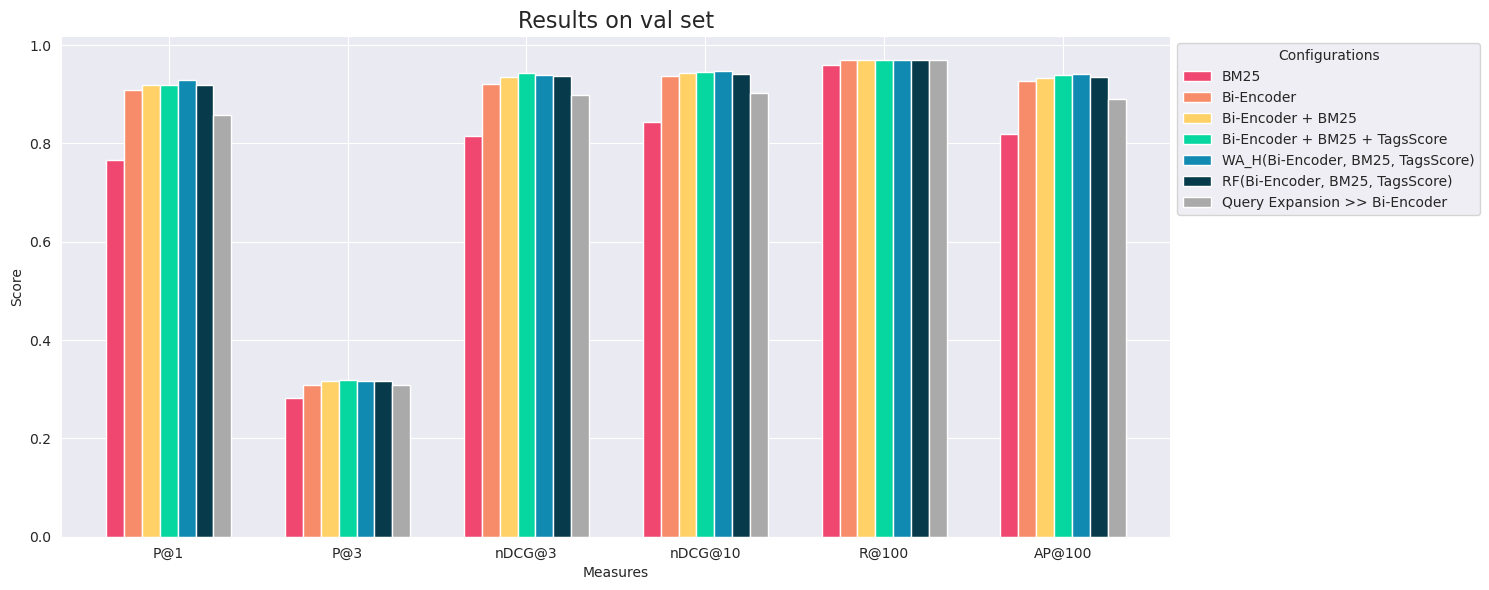

In [12]:
plot_df = results.drop('mrt', axis=1).set_index('name')
colors = ['#ef476f', '#f78c6b', '#ffd166', '#06d6a0', '#118ab2', '#073b4c', '#aaaaaa']
ax = plot_df.T.plot(kind='bar', figsize=(15, 6), color=colors, width=0.7)

plt.title('Results on val set', fontsize=16)
plt.xlabel('Measures')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(title='Configurations', bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()


Best model on P@1: **tags score model (weighted average with heuristics)**, `name = 'WA_H(Bi-Encoder, BM25, TagsScore)`

$\text{BM25 \% 100} >> 
\begin{cases}
    .7 \cdot \text{BiEncoder\_score} + .1 \cdot \text{BM25\_score} + .2 \cdot \text{tags\_score}, &\quad\text{if \, num\_questions}\ge 512\\
    .9 \cdot \text{BiEncoder\_score} + .1 \cdot \text{BM25\_score}, &\quad\text{otherwise.} \\ 
\end{cases}$

Now we look at the results of the test for this model.

In [13]:
metrics = [P@1, P@3, nDCG@3, nDCG@10, R@100, MAP@100, 'mrt']

results = pt.Experiment(
    [reranking_personalized_heuristics],
    test_queries,
    test_qrels,
    eval_metrics=metrics,
    names=["TEST - WA_H(Bi-Encoder, BM25, TagsScore)"],
)

# the query expansion is just loaded, because it takes a lot of time to compute
path = "./experiments/results_test_final.csv"
results.to_csv(path)

display(results.round(3))

,name,P@1,P@3,nDCG@3,nDCG@10,R@100,AP@100,mrt
0,"TEST - WA_H(Bi-Encoder, BM25, TagsScore)",0.878,0.306,0.901,0.915,0.969,0.902,73.27



For this model we get: 
- P@1 = 0.878: the correct answer at the first position the 87.8% of the times
- P@3 = 0.306: the correct answer in the top 3 positions the 91.8% of the times
- R@100 = 0.969: the correct answer in the top 100 positions the 96.9% of the times.

These results can be considered quite good. When the best answer is retrieved by BM25 % 100 in the first-stage retrieval, it is almost always ranked within the top 3 positions.

### Considerations

Finally, we would like to say what impressed us the most. First, the ability of BERT-like models to understand text. It's incredible how good the results are by simply computing the cosine similarity between the embeddings of the question and the answers. Second, the fact that a lightweight statistical model can achieve such good results; this achievement opens up the possibility of creating a reranking pipeline, which is a very clever and simple way to reduce the computational load of a neural model.

We believe that the tag score doesn't have a significant impact because we observed that most users have only posted one question on the platform, which in many cases leads to a cold start problem. In addition, the powerful capabilities of the Bi-Encoder model result in an overly influential score, so the other scores don't have much of a chance to shine.


---

Thanks for the attention!

Armanni Luca

Ghiotto Alessandro
